# Pricing Model

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [28]:
X = pd.read_csv('sp500/data.csv').reset_index()
X['date'] = pd.to_datetime(X['date'])
X = X.loc[(X['date'].dt.year == 2022) & (X['date'].dt.month == 12)]

Y = pd.read_csv('sp500/target.csv').reset_index()
Y['date'] = pd.to_datetime(Y['date'])
Y = Y.loc[(Y['date'].dt.year == 2023) & (Y['date'].dt.month == 12)].loc[~(Y['ticker'] == '^GSPC')][['ticker', 'price']].dropna()
common_tickers = set(Y['ticker']).intersection(X['ticker'])
X = X.drop(columns=['date'])

X = X.loc[X['ticker'].isin(common_tickers)].set_index('ticker').sort_index().drop(columns=['index'])
Y = Y.loc[Y['ticker'].isin(common_tickers)].set_index('ticker').sort_index()

<Axes: >

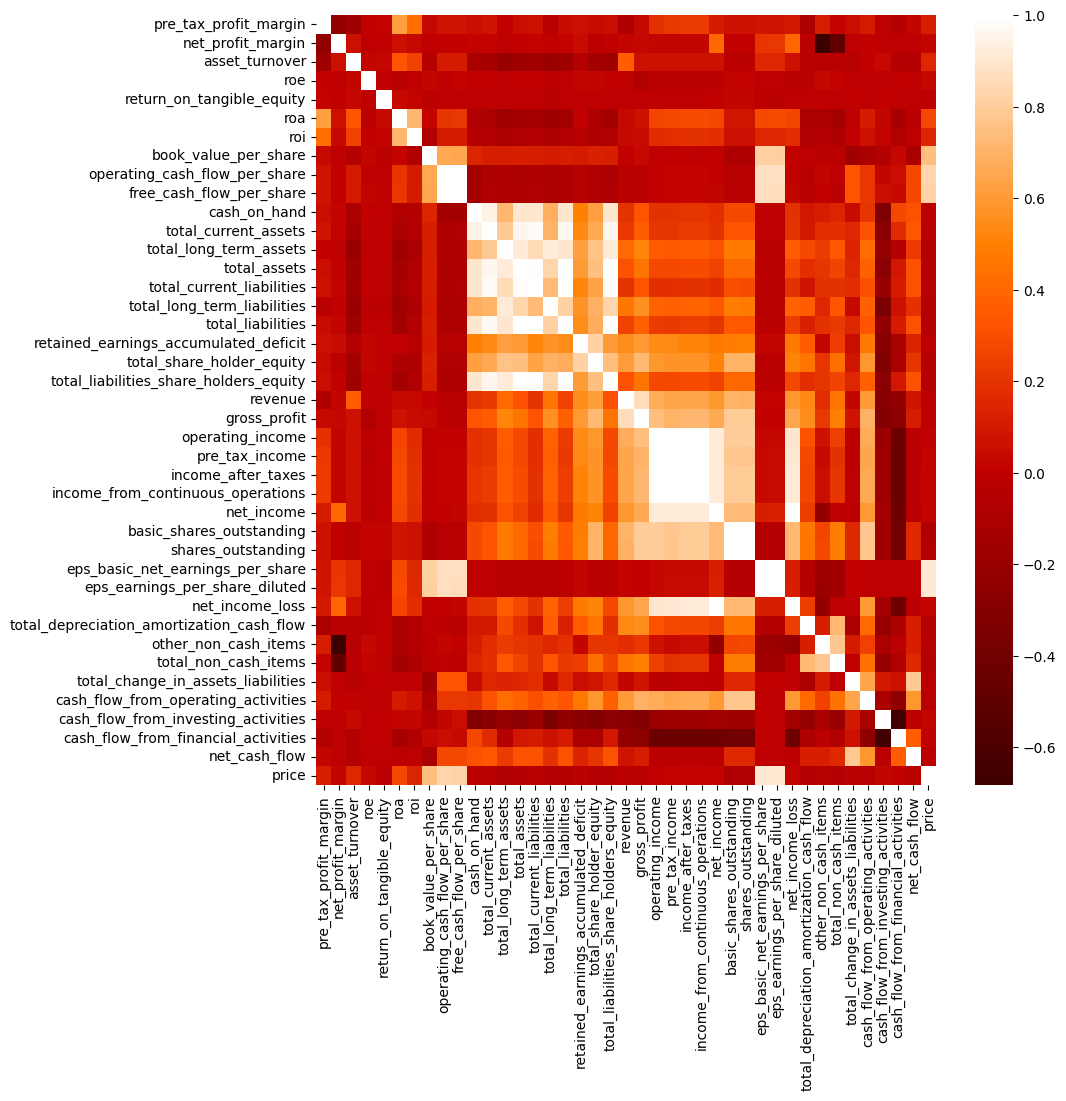

In [29]:
fig, ax = plt.subplots(figsize=(10,10))

correlation_matrix = X.join(Y).corr()
sns.heatmap(correlation_matrix, cmap='gist_heat', center=0, ax=ax)

In [30]:
correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()['price']

eps_basic_net_earnings_per_share         0.907767
free_cash_flow_per_share                 0.819169
book_value_per_share                     0.744002
asset_turnover                           0.151392
roe                                      0.030176
cash_flow_from_investing_activities      0.017982
net_income                               0.013363
income_after_taxes                       0.008756
income_from_continuous_operations        0.008430
pre_tax_income                           0.007600
cash_flow_from_financial_activities      0.003693
net_cash_flow                           -0.012207
retained_earnings_accumulated_deficit   -0.015530
gross_profit                            -0.017605
cash_on_hand                            -0.019848
revenue                                 -0.021356
cash_flow_from_operating_activities     -0.032666
total_current_assets                    -0.036507
other_non_cash_items                    -0.044160
total_long_term_liabilities             -0.067584


                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.907
Model:                            OLS   Adj. R-squared (uncentered):              0.895
Method:                 Least Squares   F-statistic:                              76.04
Date:                Wed, 18 Dec 2024   Prob (F-statistic):                   1.34e-133
Time:                        17:46:05   Log-Likelihood:                         -621.54
No. Observations:                 342   AIC:                                      1321.
Df Residuals:                     303   BIC:                                      1471.
Df Model:                          39                                                  
Covariance Type:            nonrobust                                                  
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------

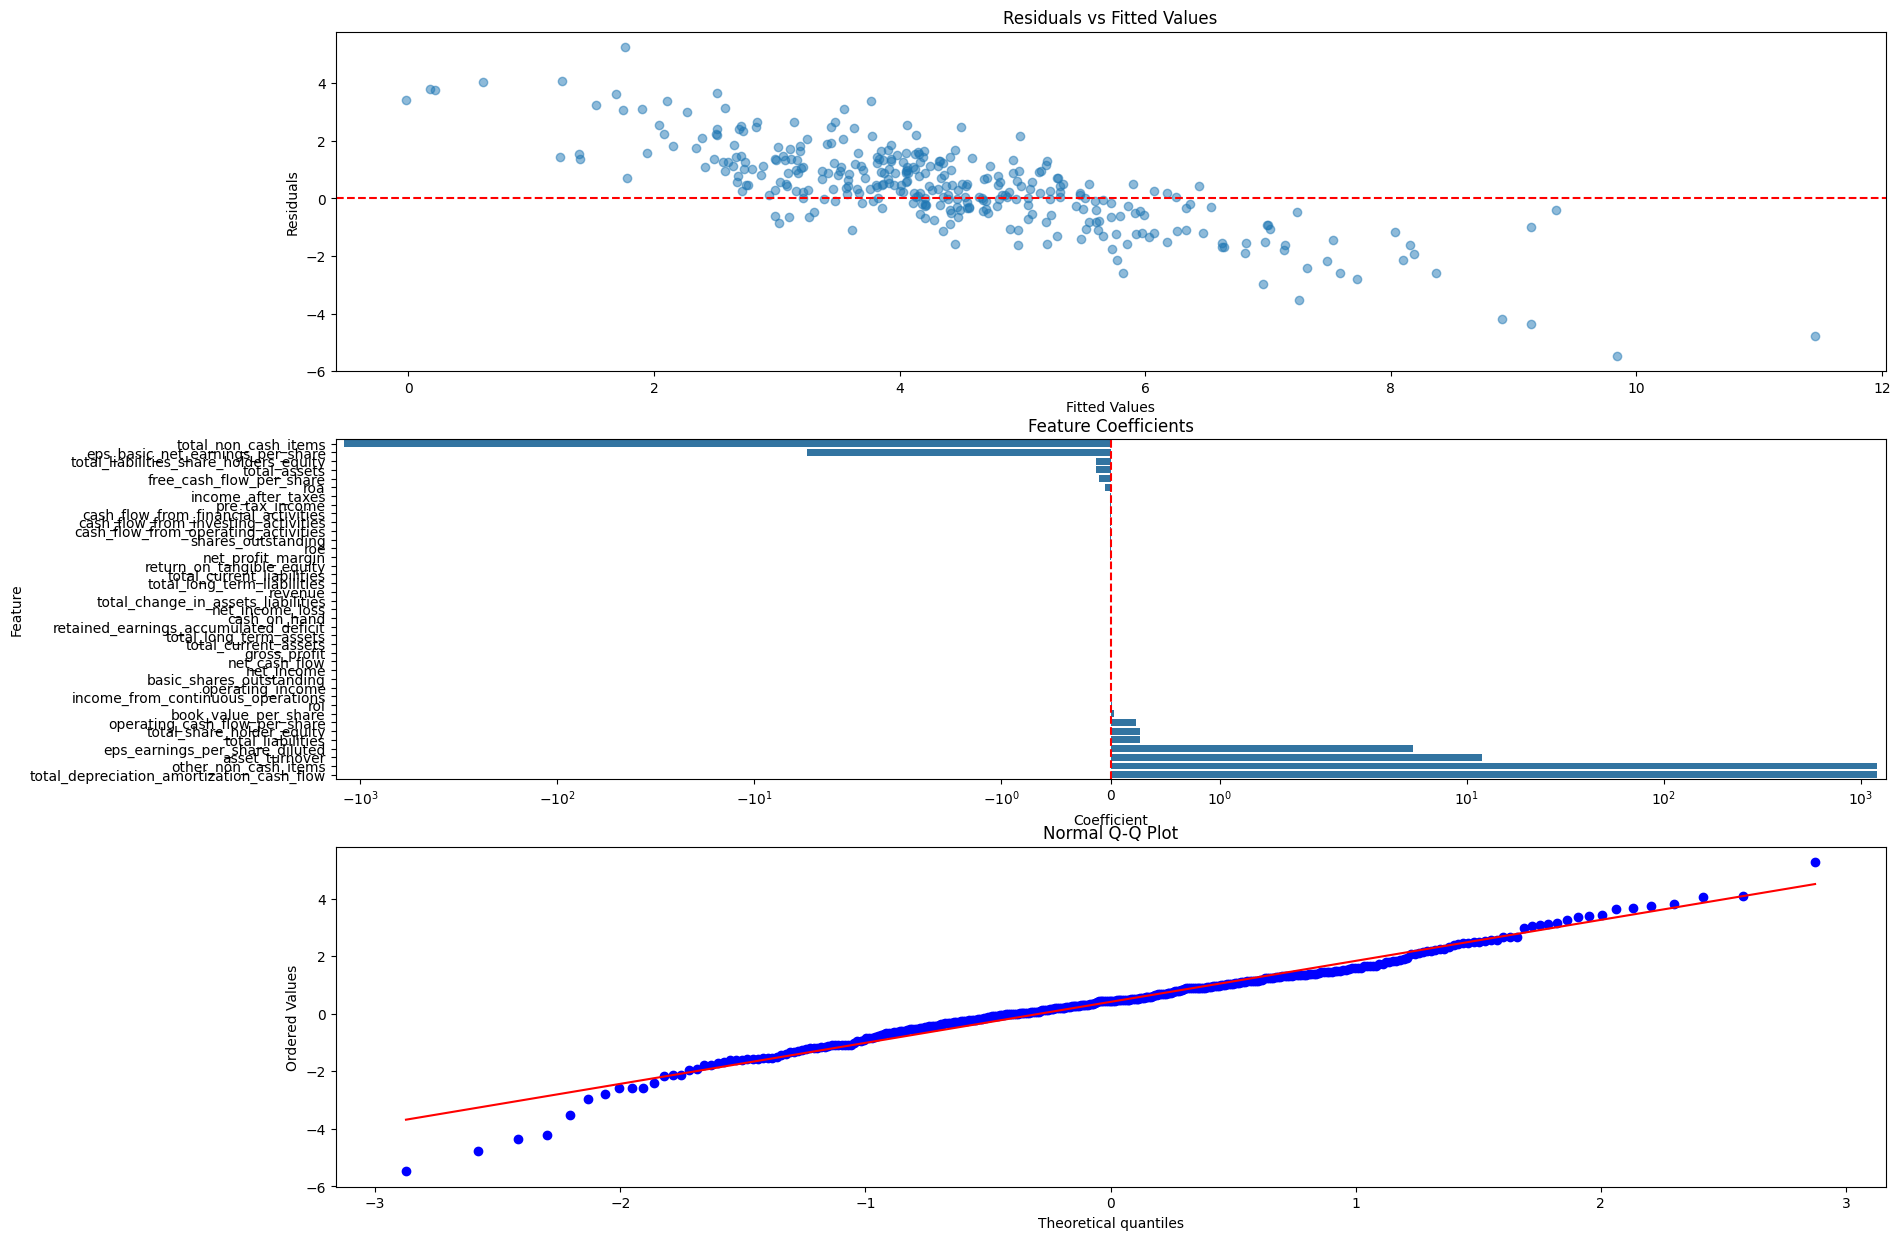

In [32]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan


def plot_regression_diagnostics(model, X, y):
    predictions = model.fittedvalues
    residuals = model.resid
    standardized_residuals = model.get_influence().resid_studentized_internal
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20, 15))
    
    ax1.scatter(predictions, residuals, alpha=0.5)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Fitted Values')
    ax1.set_ylabel('Residuals')
    ax1.set_title('Residuals vs Fitted Values')
    
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.params[1:],
        'P-value': model.pvalues[1:]
    }).sort_values('Coefficient', ascending=True)
    
    sns.barplot(data=coef_df, x='Coefficient', y='Feature', ax=ax2)
    ax2.axvline(x=0, color='r', linestyle='--')
    ax2.set_title('Feature Coefficients')
    ax2.set_xscale('symlog')

    stats.probplot(residuals, dist="norm", plot=plt)
    ax3.set_title('Normal Q-Q Plot')

    return fig

model = sm.OLS(np.log(Y), X)
results = model.fit()
print(results.summary())
fig1 = plot_regression_diagnostics(results, X.iloc[:, 1:], Y)  # Exclude constant term from X
